In [ ]:
# Understanding and implementing Encoder Decoder based Image denoising model for
# cleaning the noise from the image and making it better.

In [1]:
import torch
import torchvision
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import warnings
import random
from torchsummary import summary

In [2]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
random.seed(33)
torch.__version__

'2.1.0+cu118'

In [3]:
def getTransformFn(image_size):
    compose = v2.Compose([v2.RandomHorizontalFlip(),
                                  v2.Resize((image_size, image_size)),
                                  v2.ToImage(),
                                  v2.ToDtype(torch.float32, scale=True)
                                  ])
    return compose


def showData(data_point, image_size):
    plt.imshow(data_point[0].numpy().reshape(image_size, image_size), cmap='gray')
    plt.title('y = ' + str(data_point[1]))
    plt.show()

In [4]:
# download image dataset Fashion MNIST images
def get_train_dataset(image_size):
  transform = getTransformFn(image_size)
  train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                    download=True,
                                                    transform=transform)
  return train_dataset

def get_validate_dataset(image_size):
  compose = v2.Compose([v2.Resize((image_size, image_size)),
                                v2.ToImage(),
                                v2.ToDtype(torch.float32, scale=True)])
  validate_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                                       download=True,
                                                       transform=compose)
  return validate_dataset

In [5]:
# hyper parameters
image_size = 28
channels = 1
batch_size = 100

train_dataloader = DataLoader(dataset=get_train_dataset(image_size), batch_size=batch_size)
validate_dataloader = DataLoader(dataset=get_validate_dataset(image_size), batch_size=batch_size)

100%|██████████| 26421880/26421880 [00:01<00:00, 15646850.02it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 277266.11it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5055993.77it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19227317.00it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
data = get_train_dataset(image_size)
len(data)

60000

In [7]:
# Input image dataset
data[0][0].shape

torch.Size([1, 28, 28])

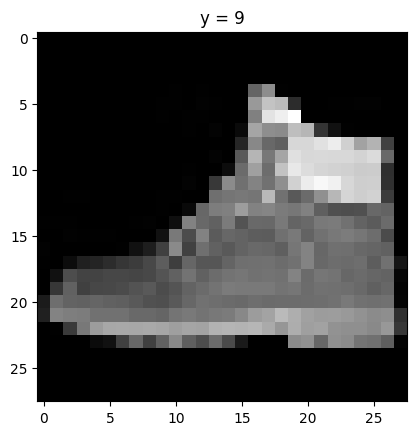

In [8]:
showData(data[90], image_size)

In [9]:
# show image with noise
def showNoisyData(data_point, image_size, noise_factor):
  data_point = data_point[0] + torch.randn_like(data_point[0])*noise_factor
  data_point = torch.clip(data_point, min=0.0, max=1.0)
  plt.imshow(data_point.numpy().reshape(image_size, image_size), cmap='gray')
  plt.show()

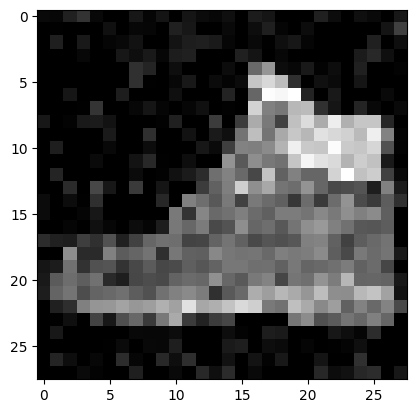

In [10]:
showNoisyData(data[90], image_size, 0.1)

In [11]:
# Encoder Decoder based Image Denoising model
class ImageDenoisingModel(nn.Module):

  def __init__(self, image_size, channels=1):
     super(ImageDenoisingModel, self).__init__()

     self.image_size = image_size
     self.channels = channels
     self.conv2d_1 = nn.Conv2d(in_channels=self.channels, out_channels=32, kernel_size=3, stride=2, padding=1)
     self.relu1 = nn.ReLU()
     self.conv2d_2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1)
     self.relu2 = nn.ReLU()

     self.conv_transpose_1 = nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
     self.relu3 = nn.ReLU()
     self.conv_transpose_2 = nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
     self.relu4 = nn.ReLU()
     self.conv2d_3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)
     self.sigmoid = nn.Sigmoid()



  def forward(self, x):

    x = self.conv2d_1(x)
    x = self.relu1(x)
    x = self.conv2d_2(x)
    x = self.relu2(x)

    x = self.conv_transpose_1(x)
    x = self.relu3(x)
    x = self.conv_transpose_2(x)
    x = self.relu4(x)
    x = self.conv2d_3(x)
    x = self.sigmoid(x)

    return x

In [12]:
# Printing model summary and number of trainable parameters
model1 = ImageDenoisingModel(28, channels=1)
summary(model1, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
              ReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 16, 7, 7]           4,624
              ReLU-4             [-1, 16, 7, 7]               0
   ConvTranspose2d-5           [-1, 32, 14, 14]           4,640
              ReLU-6           [-1, 32, 14, 14]               0
   ConvTranspose2d-7           [-1, 64, 28, 28]          18,496
              ReLU-8           [-1, 64, 28, 28]               0
            Conv2d-9            [-1, 1, 28, 28]             577
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 28,657
Trainable params: 28,657
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.98
Params size (MB): 0.11
Estimated Tot

In [14]:
# training model
def train_model(model, train_loader, validation_loader, optimizer, image_size, n_epochs=5, noise_factor=0.2):
  # global variable
  N_test = len(get_validate_dataset(image_size))
  print(" Number of test images: ", N_test)
  accuracy_list = []
  loss_list = []
  criterion = nn.MSELoss()

  for epoch in range(n_epochs):
    print(" starting epoch number {}/{} ....".format(epoch, epochs))

    for x, label in train_loader:
      # call train() on model which extents nn.module
      #if cuda:
      #  x, label = x.cuda(), label.cuda()
      #  model = model.cuda()

      # adding noise to the image
      data = x + torch.randn_like(x)*noise_factor
      data = torch.clip(data, min=0.0, max=1.0)

      model.train()
      # reset the weights derivative values
      optimizer.zero_grad()
      # predict the output
      pred = model(data)
      # calculate Mean Squared loss
      loss = criterion(pred, x)
      # Calculate derivative of loss w.r.t weights
      loss.backward()
      # update the weights value
      optimizer.step()

      loss_list.append(loss.data)

  return loss_list

In [15]:
lr = 0.0005
epochs = 10
model = ImageDenoisingModel(image_size, channels)
optimizer = torch.optim.Adam(model.parameters())

In [16]:
loss = train_model(model, train_dataloader, validate_dataloader, optimizer, image_size, epochs, 0.1)

 Number of test images:  10000
 starting epoch number 0/10 ....
 starting epoch number 1/10 ....
 starting epoch number 2/10 ....
 starting epoch number 3/10 ....
 starting epoch number 4/10 ....
 starting epoch number 5/10 ....
 starting epoch number 6/10 ....
 starting epoch number 7/10 ....
 starting epoch number 8/10 ....
 starting epoch number 9/10 ....


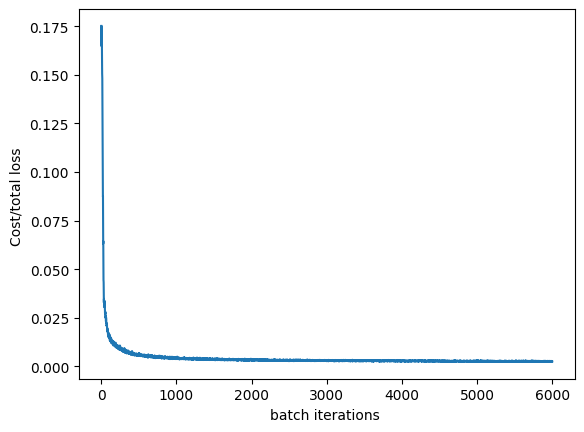

In [17]:
# plotting loss graph for training
plt.plot(loss)
plt.xlabel("batch iterations ")
plt.ylabel("Cost/total loss ")
plt.show()

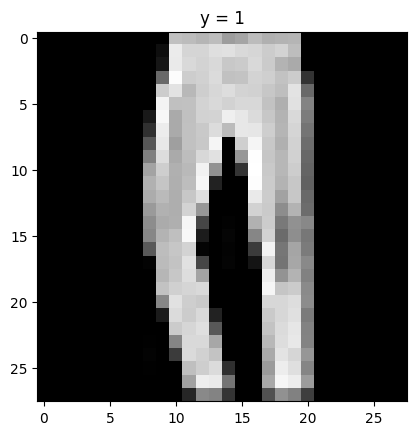

In [18]:
validate_data = get_validate_dataset(image_size)
showData(validate_data[5], image_size)

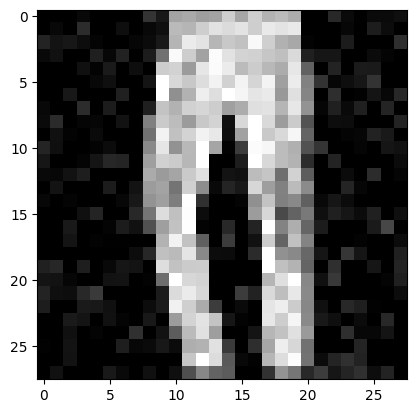

In [20]:

showNoisyData(validate_data[5], image_size, 0.1)

In [21]:
# evaluating on the new image
model.eval()
noise_factor = 0.1
data_point = validate_data[5][0] + torch.randn_like(validate_data[5][0])*noise_factor
data_point = torch.clip(data_point, min=0.0, max=1.0)
output = model(data_point)

In [22]:
output.shape

torch.Size([1, 28, 28])

In [23]:
def showDataPredicted(data_point, image_size):
    plt.imshow(data_point.numpy().reshape(image_size, image_size), cmap='gray')
    plt.show()

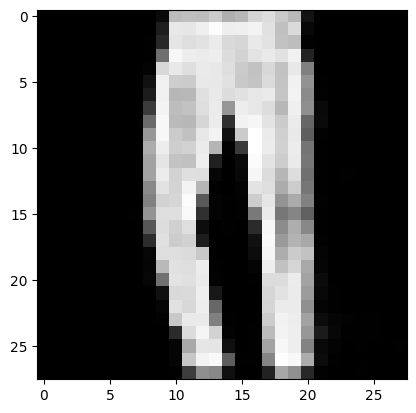

In [24]:
showDataPredicted(output.detach(), image_size)